# Exploratory Data Analysis & Modeling

In [24]:
from radiant_mlhub import Dataset, Collection, client, get_session
import tarfile
from pathlib import Path
import os
import shutil
from io import BytesIO
from glob import glob
from tqdm.notebook import tqdm
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import json
import seaborn as sns

## Load Data

In [25]:
# Main dataset
dataset_df = pd.read_json("dataset_df.json")

# View first five rows
dataset_df.head()

,source_file,label
0,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,banana
1,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,maize
2,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,legumes
3,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,legumes
4,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure


In [26]:
# Dataframe containing the keys
key_df = pd.read_json("key_df.json")

# View first five rows
key_df.head()

,index,source_file,label
0,4,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
1,5,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
2,8,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
3,9,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure
4,10,C:\Users\jenna\Documents\MCP\Spring_2022\MUSA6...,structure


In [27]:
# Output path where the data is located and version of the path as a string
output_path = Path("./data/").resolve()
output_path_str = str(Path(output_path))

In [28]:
# Access to the data on local system
data_root=f"{output_path}/Images" 

In [29]:
# Print classes from the Images folder
selectedClasses = (os.listdir(data_root))
print (selectedClasses)

['banana', 'forest', 'legumes', 'maize', 'other', 'structure']


In [30]:
# How many images are in the dataset
print("Total images in the dataset: ", len(dataset_df))

Total images in the dataset:  2606


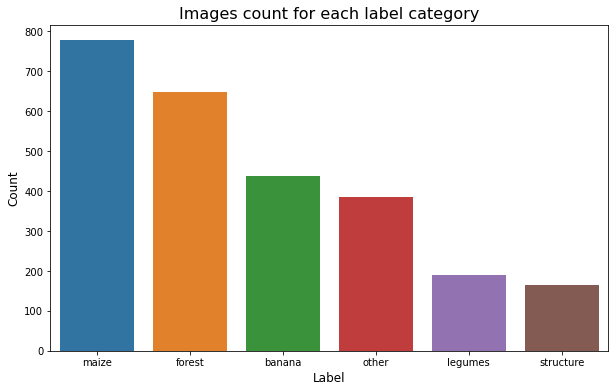

In [31]:
# Check image counts per category, just for reference
ac_count = dataset_df['label'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=ac_count.index, y=ac_count.values)
plt.title("Images count for each label category", fontsize=16)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show();

In [32]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf #deep learning


### Plot some sample images before any data augmentation

In [33]:
TRAINING_DATA_DIR = str(data_root) #data directory for training

In [34]:
train_datagen_plot = ImageDataGenerator()
train_generator_plot = train_datagen_plot.flow_from_directory(
    TRAINING_DATA_DIR,
    target_size=(224, 224), #image size
    shuffle = True, #randomize the data for training
    subset='training')

Found 2606 images belonging to 6 classes.


In [35]:
#plots images with labels
def plots(ims, figsize = (10,10), rows=4, interp=False, titles=None, maxNum = 10):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation = None if interp else 'none')  

In [36]:
train_generator_plot.reset()
imgs, labels = train_generator_plot.next() # images to plot

# including labels
labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]

for ind in labelIndices:
    for labelName,labelIndex in train_generator_plot.class_indices.items():
        if labelIndex == ind:
            labelNames.append(labelName)

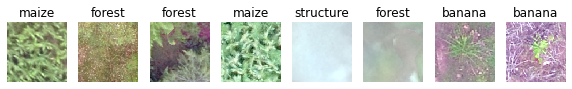

In [37]:
plots(imgs, rows=1, titles = labelNames, maxNum=8)


### Creating data matrices

In [23]:
#checking format of imgs matrix
np.asarray(imgs).shape

#looks like 32 images that are 224x224 and 3 color channels...

(32, 224, 224, 3)

In [75]:
#reading images from local images folder -- replace and comment out the duplicate
dataPath = "C:/Users/kchan/Desktop/Spring2022/RemoteSensing/Final/FinalRepo/MUSA650_Final_ChangEpstein/data/Images"
#dataPath = "JENNA PUT YOURS HERE"

#array of unique labels
labelList = os.listdir(dataPath)

#read images
numClass = len(labelList)

lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
    lenClass[i] = len(os.listdir(dataPath + '/' + labelList[i]))
#returns the number of images in each class
lenClass 

array([438., 649., 190., 778., 385., 166.])

In [77]:
#returns the total number of images
numImg = int(lenClass.sum())

2606

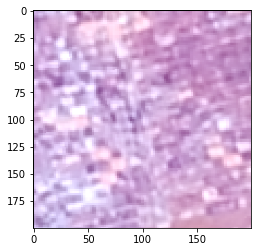

In [120]:
#plotting one image
import PIL

imgSel = dataPath + '/' + labelList[i] + '/' + os.listdir(dataPath + '/' + labelList[i])[29] #this can be any number between 0-165 idk why
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))

In [123]:
np.asarray(img).shape
#200x200 and 3 color channels - does it need to be 224x224?

(200, 200, 3)

In [124]:
#returns total number of pixels per each image
numPixels = np.prod(np.asarray(img).shape)
numPixels

120000

In [125]:
#extract color channels from each image and flatten to a feature matrix X
X = np.zeros([numImg, numPixels])

#create the labels y(with binary labels 0 and 1) for each image
y = np.zeros(numImg)

In [170]:
imgInd = 0
for i in np.arange(0, numClass):
  className = labelList[i]
  for imgName in os.listdir(dataPath + '/' + className):
    img = PIL.Image.open(dataPath + '/' + className + '/' + imgName, 'r')
    imgVec = np.asarray(img).flatten()
    X[imgInd,:] = imgVec
    y[imgInd] = i
    imgInd = imgInd + 1
    print('Read img class ' + className + ' no ' + str(imgInd))

Read img class banana no 1
Read img class banana no 2
Read img class banana no 3
Read img class banana no 4
Read img class banana no 5
Read img class banana no 6
Read img class banana no 7
Read img class banana no 8
Read img class banana no 9
Read img class banana no 10
Read img class banana no 11
Read img class banana no 12
Read img class banana no 13
Read img class banana no 14
Read img class banana no 15
Read img class banana no 16
Read img class banana no 17
Read img class banana no 18
Read img class banana no 19
Read img class banana no 20
Read img class banana no 21
Read img class banana no 22
Read img class banana no 23
Read img class banana no 24
Read img class banana no 25
Read img class banana no 26
Read img class banana no 27
Read img class banana no 28
Read img class banana no 29
Read img class banana no 30
Read img class banana no 31
Read img class banana no 32
Read img class banana no 33
Read img class banana no 34
Read img class banana no 35
Read img class banana no 36
R

In [171]:
#shape of X before splitting
X.shape

(2606, 120000)

In [172]:
#shape of y before splitting
y.shape

(2606,)

### KNN Model

In [173]:
#splitting the data, using stratify to ensure even distribution of each classes in each set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None, stratify=y)


In [174]:
X_train.shape

(2084, 120000)

In [175]:
X_test.shape

(522, 120000)

In [194]:
#defining knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=22) #using 22 from gridSearchCV

In [195]:
#scale and transform
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [196]:
#train the model
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=22)

In [197]:
#apply the model
knn_preds = knn_clf.predict(X_test)

In [198]:
#evaluate model
from sklearn.metrics import accuracy_score, plot_confusion_matrix
accuracy_score(y_test, knn_preds)

0.42528735632183906

In [192]:
#optimize parameters -- NOTE: this takes 10 min ito run
#source: https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/
from sklearn.model_selection import GridSearchCV
#defining range of parameters
k_range = list(range(1,31))
param_grid_knn = dict(n_neighbors = k_range)

#defining grid
grid_knn = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

#fitting model for grid search
grid_search_knn = grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [193]:
#print best parameters
print(grid_search_knn.best_params_)

#10 folds for 30 candidates range(1,31) defines 22 neighbors as optimal

{'n_neighbors': 22}


### Random Forest

In [215]:
#defining classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=15, n_estimators=200, max_features=1)

In [216]:
#train the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=1, n_estimators=200)

In [217]:
#apply the model
rf_preds = rf_clf.predict(X_test)

In [218]:
#evaluate model
accuracy_score(y_test, rf_preds)

0.6206896551724138

In [213]:
#optimize parameters - should only take <5 min to run currently
#source: https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
#defining range of parameters
param_grid_rf = {
    'max_depth': [5, 10, 15],
    'n_estimators': [200, 700, 900]
}

#defining grid
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

#fitting model for grid search
grid_search_rf = grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [214]:
#print best parameters
print(grid_search_rf.best_params_)

#10 folds for 4 candidates {'max_depth': [5, 10],'n_estimators': [200, 700]} defines optimal:
#max depth: 10, n_estimators: 700

#10 folds for 9 candidates {'max_depth': [5, 10, 15],'n_estimators': [200, 700, 900]} defines optimal:
#max depth: 15, n_estimators: 200

{'max_depth': 15, 'n_estimators': 200}
